<a href="https://colab.research.google.com/github/arturbernardo/data_stars/blob/main/Gaia2Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyvo
!pip install mocpy
!pip install astropy
!pip install ipyaladin
!pip install astroquery

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 999.4/999.4 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.7/220.7 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 765.5/765.5 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 85.7 MB/s eta 0:00:00


In [7]:
# Access astronomical databases
from pyvo import registry  # version >=1.6

# Moc and HEALPix tools
from mocpy import MOC

# Coordinates manipulation
from astropy.coordinates import SkyCoord

# Sky visualization
from ipyaladin import Aladin  # version >=0.4.0

# For plots
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import math

from matplotlib.colors import LinearSegmentedColormap


In [3]:
from astroquery.gaia import Gaia
Gaia.MAIN_GAIA_TABLE = "gaiadr2.gaia_source"  # Select Data Release 2
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"  # Reselect Data Release 3, default

https://astroquery.readthedocs.io/en/latest/gaia/gaia.html

In [4]:
from astroquery.gaia import Gaia
gaiadr3_table = Gaia.load_table('gaiadr3.gaia_source')
print(gaiadr3_table)


TAP Table name: gaiadr3.gaia_source
Description: This table has an entry for every Gaia observed source as published with this data release. It contains the basic source parameters, in their final state as processed by the Gaia Data Processing and Analysis Consortium from the raw data coming from the spacecraft. The table is complemented with others containing information specific to certain kinds of objects (e.g.~Solar--system objects, non--single stars, variables etc.) and value--added processing (e.g.~astrophysical parameters etc.). Further array data types (spectra, epoch measurements) are presented separately via Datalink resources.
Size (bytes): 3646930329600
Num. columns: 152


In [ ]:
# job = Gaia.launch_job("select top 100 "
#                       "parallax, bp_rp, phot_g_mean_mag "
#                       "from gaiadr3.gaia_source order by source_id")
# r = job.get_results()
# # print(r['parallax'])
# print(r)

In [ ]:
# job = Gaia.launch_job("select "
#                       "* "
#                       "from gaiadr3.gaia_source order by source_id")
# r = job.get_results()
# print(r.colnames)

['solution_id', 'designation', 'source_id', 'random_index', 'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'parallax_over_error', 'pm', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_n_obs_al', 'astrometric_n_obs_ac', 'astrometric_n_good_obs_al', 'astrometric_n_bad_obs_al', 'astrometric_gof_al', 'astrometric_chi2_al', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'astrometric_params_solved', 'astrometric_primary_flag', 'nu_eff_used_in_astrometry', 'pseudocolour', 'pseudocolour_error', 'ra_pseudocolour_corr', 'dec_pseudocolour_corr', 'parallax_pseudocolour_corr', 'pmra_pseudocolour_corr', 'pmdec_pseudocolour_corr', 'astrometric_matched_transits', 'visibility_periods_used', 'astrometric_sigma5d_max', 'matched_transits', 'new_matched_transits', 

In [85]:
# job = Gaia.launch_job("select TOP 500 "
#                       "parallax, bp_rp, phot_g_mean_mag, phot_g_mean_flux "
#                       "from gaiadr3.gaia_source"
#                       " WHERE parallax > 0 "
#                       " AND bp_rp IS NOT NULL "
#                       " AND parallax_over_error > 10 "
#                       " AND phot_g_mean_mag IS NOT NULL "
#                       " AND astrometric_primary_flag = 'true' "
#                       " ORDER BY random_index ")

job = Gaia.launch_job("""
    SELECT TOP 3000
        parallax, bp_rp, phot_g_mean_mag,
        phot_bp_mean_flux_over_error,
        phot_rp_mean_flux_over_error,
        visibility_periods_used,
        astrometric_chi2_al,
        astrometric_n_good_obs_al,
        astrometric_primary_flag
    FROM gaiadr3.gaia_source
    WHERE
        parallax > 0
        AND parallax_over_error > 5
        AND phot_g_mean_mag IS NOT NULL
        AND bp_rp IS NOT NULL
        AND phot_bp_mean_flux_over_error > 5
        AND phot_rp_mean_flux_over_error > 5
        AND visibility_periods_used > 5
        AND astrometric_chi2_al / (astrometric_n_good_obs_al - 5) < 2.5
    ORDER BY random_index
""")
        # AND astrometric_primary_flag = 'true'


r = job.get_results()
# print(r['parallax'])
df = r.to_pandas()



In [58]:
# print(df[['parallax', 'distancia']].head())
# print(df['phot_g_mean_mag'].describe())
print(df['log_L'].describe())
print(df['M'].describe())

count    500.000000
mean      -2.034530
std        0.832319
min       -4.679774
25%       -2.454673
50%       -1.977555
75%       -1.572764
max        0.137636
Name: log_L, dtype: float64
count    500.000000
mean       9.916324
std        2.080798
min        4.485910
25%        8.761911
50%        9.773888
75%       10.966682
max       16.529434
Name: M, dtype: float64


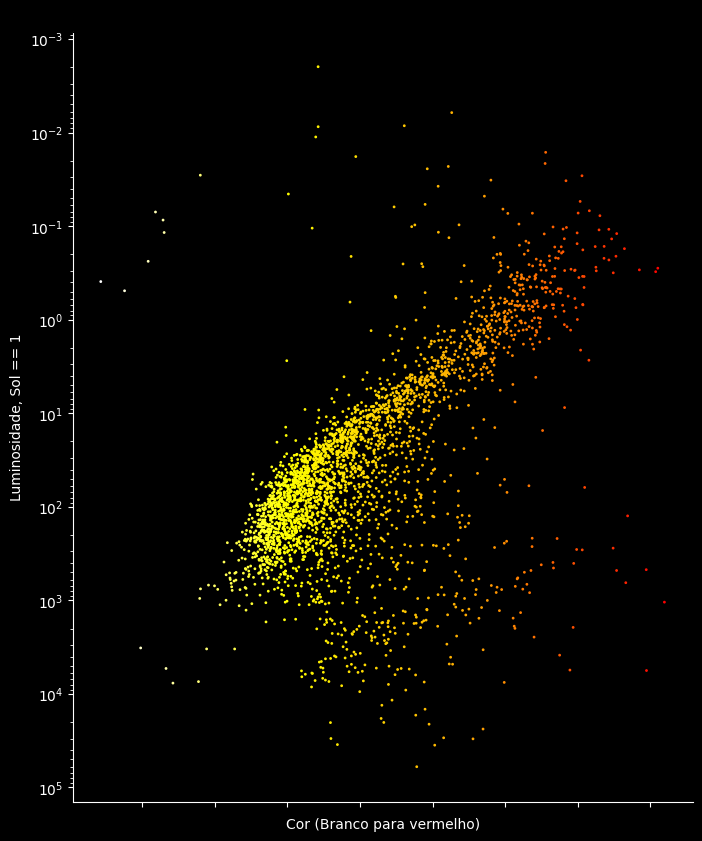

In [93]:
# ax.invert_yaxis()  # ESSENCIAL para parecer com um HR clássico!
# plt.ylabel('Magnitude Absoluta (G)')


df['distancia'] = 1 / df['parallax'] / 1000

M_sun = 4.83

df['M'] = df['phot_g_mean_mag'] + 5 * np.log10(df['parallax']/100) - 5

df['log_L'] = -0.4 * (df['M'] - M_sun)
df['L'] = 10 ** df['log_L']

norm = plt.Normalize(vmin=df['log_L'].min(), vmax=df['log_L'].max())

colors = ['white', 'yellow', 'orange', 'red']
n_bins = 500
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=n_bins)

fig, ax = plt.subplots()
ax.set_xticklabels([])
# ax.set_yticklabels([0, 0.0001, 0.01, 1, 100, 100000])
fig.set_figheight(10)
fig.set_figwidth(8)

fig.patch.set_facecolor('black')
ax.set_facecolor('black')

ax.spines['left'].set_color('orange')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')
ax.tick_params(colors='white', which='both')

ax.set_yscale('log')
# plt.scatter(df['bp_rp'], df['log_L'], s=1, cmap=cmap, c=df['bp_rp'], norm=norm)
plt.scatter(df['bp_rp'], df['L'], s=1, c=df['bp_rp'], cmap=cmap)
plt.xlabel('Cor (Branco para vermelho)')
plt.ylabel('Luminosidade, Sol == 1')
plt.title('Diagrama HR')
# plt.gca().invert_yaxis()
ax.invert_yaxis()
plt.grid(False)

plt.show()


In [ ]:
max(df['log_L']) #4.1959205689949375
# min(df['log_L']) #-4.76432937740283


6.195920568994938

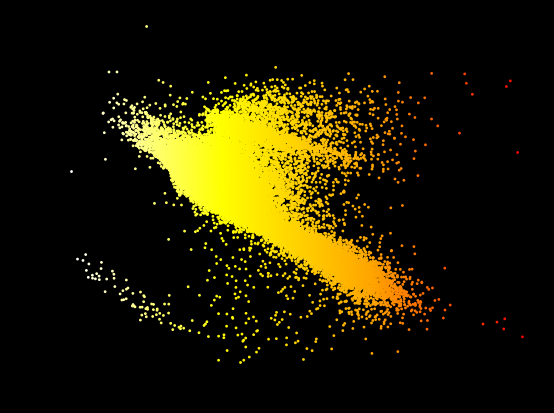

In [14]:

colors = ['white', 'yellow', 'orange', 'red']  # Cores do gradiente
n_bins = 500  # Número de bins para o gradiente

# Criar o colormap
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=n_bins)
fig, ax = plt.subplots()
fig.patch.set_facecolor('black')         # Fundo da figura
ax.set_facecolor('black')                # Fundo dos eixos
sc = plt.scatter(
    df['bp_rp'], df['M'],
    c=df['bp_rp'],          # Essa é a parte que muda a cor com o valor
    cmap=cmap,          # Pode testar 'viridis', 'coolwarm', 'inferno'...
    s=1
)
# plt.colorbar(sc, label='BP - RP')  # Adiciona uma barra de cores
plt.gca().invert_yaxis()  # opcional: inverso para parecer com versão clássica


In [10]:
df

,parallax,bp_rp,phot_g_mean_mag,distancia,M,log_L
0,1.084924,1.522128,15.244129,0.921724,0.421125,1.763550
1,0.352725,2.438201,14.802705,2.835071,-2.460115,2.916046
2,0.674962,1.305249,16.073896,1.481564,0.220294,1.843882
3,0.886435,0.986587,14.375696,1.128114,-0.886069,2.286428
4,7.191948,1.819450,13.987773,0.139044,3.272006,0.623198
...,...,...,...,...,...,...
49995,0.432717,1.017873,16.344067,2.310980,-0.474915,2.121966
49996,0.760619,1.346244,16.377256,1.314719,0.783091,1.618764
49997,1.481341,1.428806,15.769869,0.675064,1.623144,1.282743
49998,1.809030,0.701519,10.996111,0.552783,-2.716661,3.018664


In [ ]:
xyz = pd.DataFrame()
xyz['phot_g_mean_mag'] = df['phot_g_mean_mag']
xyz['bp_rp'] = df['bp_rp']
xyz['parallax'] = df['parallax']
xyz

,phot_g_mean_mag,bp_rp,parallax
0,17.641426,1.019003,0.354331
1,17.571619,2.458246,3.235017
2,14.128453,1.292233,3.139170
3,19.597301,2.346785,1.383150
4,18.135033,1.270405,0.196148
...,...,...,...
99991,16.998064,2.209311,2.454630
99992,20.525055,1.615833,0.830071
99994,19.553427,1.160318,0.310603
99995,16.079517,1.729242,1.981374


from matplotlib import pyplot as plt
xyz['phot_g_mean_mag'].plot(kind='hist', bins=20, title='phot_g_mean_mag')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
xyz['bp_rp'].plot(kind='hist', bins=20, title='bp_rp')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
xyz['parallax'].plot(kind='hist', bins=20, title='parallax')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
xyz.plot(kind='scatter', x='phot_g_mean_mag', y='bp_rp', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
xyz.plot(kind='scatter', x='bp_rp', y='parallax', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
xyz['phot_g_mean_mag'].plot(kind='line', figsize=(8, 4), title='phot_g_mean_mag')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
xyz['bp_rp'].plot(kind='line', figsize=(8, 4), title='bp_rp')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
xyz['parallax'].plot(kind='line', figsize=(8, 4), title='parallax')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
# BP - RP ~ 0.2 a 0.5 → Estrela quente, tipo espectral de A ou F (branca a amarela).

# BP - RP ~ 0.5 a 1.0 → Estrela de tipo G (amarela, como o Sol).

# BP - RP ~ 1.0 a 1.5 → Estrela de tipo K (laranja).

# BP - RP > 1.5 → Estrela de tipo M (vermelha).

In [ ]:
# ASYNC
# job = Gaia.launch_job_async("select top 100 ra, dec "
#                             "from gaiadr3.gaia_source order by source_id",
#                             dump_to_file=True, output_format='votable')

In [ ]:
for column in gaiadr3_table.columns:
  print(column.name)

solution_id
designation
source_id
random_index
ref_epoch
ra
ra_error
dec
dec_error
parallax
parallax_error
parallax_over_error
pm
pmra
pmra_error
pmdec
pmdec_error
ra_dec_corr
ra_parallax_corr
ra_pmra_corr
ra_pmdec_corr
dec_parallax_corr
dec_pmra_corr
dec_pmdec_corr
parallax_pmra_corr
parallax_pmdec_corr
pmra_pmdec_corr
astrometric_n_obs_al
astrometric_n_obs_ac
astrometric_n_good_obs_al
astrometric_n_bad_obs_al
astrometric_gof_al
astrometric_chi2_al
astrometric_excess_noise
astrometric_excess_noise_sig
astrometric_params_solved
astrometric_primary_flag
nu_eff_used_in_astrometry
pseudocolour
pseudocolour_error
ra_pseudocolour_corr
dec_pseudocolour_corr
parallax_pseudocolour_corr
pmra_pseudocolour_corr
pmdec_pseudocolour_corr
astrometric_matched_transits
visibility_periods_used
astrometric_sigma5d_max
matched_transits
new_matched_transits
matched_transits_removed
ipd_gof_harmonic_amplitude
ipd_gof_harmonic_phase
ipd_frac_multi_peak
ipd_frac_odd_win
ruwe
scan_direction_strength_k1
scan_di

In [ ]:
# the catalogue name in VizieR
CATALOGUE = "J/A+A/616/A10"
# CATALOGUE = "J/A+A/620/A128"


In [ ]:
# each resource in the VO has an identifier, called ivoid. For vizier catalogs,
# the VO ids can be constructed like this:
catalogue_ivoid = f"ivo://CDS.VizieR/{CATALOGUE}"
# the actual query to the registry
voresource = registry.search(ivoid=catalogue_ivoid)[0]

In [ ]:
# We can print metadata information about the catalogue
voresource.describe(verbose=True)

46 open clusters GaiaDR2 HR diagrams
Short Name: J/A+A/616/A10
IVOA Identifier: ivo://cds.vizier/j/a+a/616/a10
Access modes: conesearch, tap#aux, web
- tap#aux: http://tapvizier.cds.unistra.fr/TAPVizieR/tap
- webpage: http://vizier.cds.unistra.fr/viz-bin/VizieR-2?-source=J/A+A/616/A10
- conesearch: https://vizier.cds.unistra.fr/viz-
 bin/conesearch/J/A+A/616/A10/tablea1a?, description: Cone search capability
 for table J/A+A/616/A10/tablea1a (Stars in nine open clusters within 250pc)
- conesearch: https://vizier.cds.unistra.fr/viz-
 bin/conesearch/J/A+A/616/A10/tablea1b?, description: Cone search capability
 for table J/A+A/616/A10/tablea1b (Stars in 37 open clusters beyond 250pc)
- conesearch: https://vizier.cds.unistra.fr/viz-
 bin/conesearch/J/A+A/616/A10/tablea3?, description: Cone search capability
 for table J/A+A/616/A10/tablea3 (Mean parameters for clusters within 250pc)
- conesearch: https://vizier.cds.unistra.fr/viz-
 bin/conesearch/J/A+A/616/A10/tablea4?, description: Cone s

In [ ]:
voresource.get_tables()

{'J/A+A/620/A128/hqsample': <VODataServiceTable name="J/A+A/620/A128/hqsample">... 51 columns ...</VODataServiceTable>,
 'J/A+A/620/A128/lqsample': <VODataServiceTable name="J/A+A/620/A128/lqsample">... 51 columns ...</VODataServiceTable>,
 'J/A+A/620/A128/refs': <VODataServiceTable name="J/A+A/620/A128/refs">... 5 columns ...</VODataServiceTable>}

In [ ]:
tables = voresource.get_tables()
tables_names = list(tables.keys())
tables_names

['J/A+A/616/A10/tablea1a',
 'J/A+A/616/A10/tablea1b',
 'J/A+A/616/A10/tablea3',
 'J/A+A/616/A10/tablea4']

In [ ]:
# get the first table of the catalogue
first_table_name = tables_names[3]

# execute a synchronous ADQL query
tap_service = voresource.get_service("tap")
tap_records = tap_service.search(
    f'select TOP 10 * from "{first_table_name}"',
)
tap_records.fielddescs

[<FIELD ID="recno" datatype="int" name="recno" ucd="meta.record"/>,
 <FIELD ID="NMemb" datatype="short" name="NMemb" ucd="meta.number"/>,
 <FIELD ID="Cluster" arraysize="*" datatype="char" name="Cluster" ucd="meta.id.parent"/>,
 <FIELD ID="RAJ2000" datatype="double" name="RAJ2000" ref="coosys_c36160010ta4" ucd="pos.eq.ra;meta.main" unit="deg"/>,
 <FIELD ID="DEJ2000" datatype="double" name="DEJ2000" ref="coosys_c36160010ta4" ucd="pos.eq.dec;meta.main" unit="deg"/>,
 <FIELD ID="plx" datatype="double" name="plx" ucd="pos.parallax.trig" unit="mas"/>,
 <FIELD ID="e_plx" datatype="double" name="e_plx" ucd="stat.error;pos.parallax" unit="mas"/>,
 <FIELD ID="pmRA" datatype="double" name="pmRA" ref="coosys_c36160010ta4" ucd="pos.pm;pos.eq.ra" unit="mas / yr"/>,
 <FIELD ID="e_pmRA" datatype="double" name="e_pmRA" ucd="stat.error;pos.pm;pos.eq.ra" unit="mas / yr"/>,
 <FIELD ID="pmDE" datatype="double" name="pmDE" ref="coosys_c36160010ta4" ucd="pos.pm;pos.eq.dec" unit="mas / yr"/>,
 <FIELD ID="e_p

In [ ]:
tap_records.infos

{'QUERY_STATUS': 'OK',
 'PROVIDER': 'CDS',
 'QUERY': 'select TOP 10 * from "J/A+A/620/A128/hqsample"',
 'ivoid_service': 'ivo://CDS.VizieR/TAP',
 'publisher': 'ivo://CDS',
 'server_software': 'TAPVizieR-Vollt/1.1.3',
 'service_protocol': 'ivo://ivoa.net/std/TAP/v1.1',
 'request_date': '2025-04-06 18:55:10',
 'contact': 'cds-question@unistra.fr',
 'ivoid': 'ivo://CDS.VizieR/J/A+A/620/A128',
 'reference_url': 'https://cdsarc.cds.unistra.fr/viz-bin/cat/J/A+A/620/A128',
 'rights_uri': 'https://cds.unistra.fr/vizier-org/licences_vizier.html',
 'creator': 'Vioque M.',
 'article': '2018A&A...620A.128V',
 'publication_date': '2018-12-07 10:26:58+01',
 'product_type': 'Critical Comp.'}

In [ ]:
print(tap_records)

<DALResultsTable length=10>
recno       Source      Cluster  RAdeg    DEdeg     Gmag    plx    e_plx    _RA      _DE   
                                  deg      deg      mag     mas     mas     deg      deg   
int32       int64        object float64  float64  float64 float64 float64 float64  float64 
----- ----------------- ------- -------- -------- ------- ------- ------- -------- --------
  254 36629890579758592  Hyades 58.14384 11.26075  12.626  28.593   0.012 58.14306 11.26079
  494 38329666836450304  Hyades 59.56042 12.62797  15.111  21.914   0.046 59.55985 12.62802
  493 38354680725946240  Hyades 58.75658 12.48554   9.766  21.715   0.015 58.75601 12.48559
  503 38670343642226816  Hyades 58.44438 13.39193  14.832  24.163   0.025 58.44372 13.39199
  504 38929141191925760  Hyades 60.18786 13.90626   13.33  21.594   0.065  60.1873 13.90633
  394 39305036729495936  Hyades   60.926 14.99122  15.039    24.1   0.041 60.92537 14.99133
  495 40470720915966208  Hyades 58.72235 16.31552  1

NameError: name 'pd' is not defined

ˊ
 **ndice** de cor=BP−RP
Este índice de cor, que pode ser positivo ou negativo, dá uma indicação do tipo de cor da estrela. Estrelas mais azuis têm um índice de cor negativo (porque o BP será menor do que o RP), enquanto estrelas mais vermelhas terão um índice de cor positivo (porque o RP será maior do que o BP).

Índice de cor negativo → Estrela azul.

Índice de cor positivo → Estrela vermelha.

Por exemplo:

Estrelas azuis: Têm um índice de cor BP - RP negativo, o que significa que elas têm uma magnitude maior na banda azul (BP) do que na banda vermelha (RP).

Estrelas vermelhas: Têm um índice de cor BP - RP positivo, o que indica que elas são mais brilhantes na banda vermelha.

phot_proc_mode : Photometry processing mode (byte)

This flag indicates the photometric calibration process used for the source. The process is determined by the availability of colour information derived from the internally calibrated mean BP and RP source spectra. The following values are defined for Gaia DR3:

• 0: this corresponds to the ‘gold’ photometric dataset. Sources in this dataset have complete colour information.
• 1: this corresponds to the ‘silver’ photometric dataset. Sources in this dataset have incomplete colour information and therefore were calibrated using an iterative process that estimated the missing colour information from the source mean G and either BP or RP photometry (depending on which band had full colour information available) using empirical relationships derived from the gold dataset.
• 2: this corresponds to the ‘bronze’ photometric dataset. Sources in this dataset had insufficient colour information and therefore were calibrated using default colour information derived from the gold dataset.

bp_rp : BP - RP colour (float, Magnitude[mag])



phot_g_mean_mag : G-band mean magnitude (float, Magnitude[mag])

Mean magnitude in the G band. This is computed from the G-band mean flux (phot_g_mean_flux ) applying the magnitude zero-point in the Vega scale (see Section 5.4.1).

No error is provided for this quantity as the error distribution is only symmetric in flux space. This converts to an asymmetric error distribution in magnitude space which cannot be represented by a single error value.

BY CHATGPT:

3. Exemplo de campos relacionados à cor no Gaia DR2:
Aqui estão alguns campos do Gaia DR2 que podem ser relevantes:

BP_mag: A magnitude da estrela na banda azul (BP).

RP_mag: A magnitude da estrela na banda vermelha (RP).

G_mag: A magnitude na banda G (visível).

BP-RP: O índice de cor que calcula a diferença entre as magnitudes BP e RP.